## Course Project - Group 11


In [63]:
!pip install wordcloud
!pip install contractions
!pip install ipython-autotime
!pip install python-dateutil
!pip install nltk
!pip install xgboost
!pip install textblob
!pip install tqdm

time: 648 µs


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import contractions
import nltk
import pickle

from nltk.corpus import stopwords
from nltk import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

from textblob import TextBlob

from dateutil import parser
from wordcloud import WordCloud
from collections import Counter


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


from xgboost import XGBClassifier

import random

from tqdm.auto import tqdm
tqdm.pandas()
%load_ext autotime

In [7]:
# Constants
SEED = 11
SAMPLE_SIZE = 10
ARTICLE_LIMIT = 9999
WORD_FEATURES_LIMIT = 5000
MIN_CLAIMANT = 5
NUM_SIM = 20

time: 950 µs


In [8]:
random.seed(SEED)

tokenizer = RegexpTokenizer(r'\w+')
vectorizer = TfidfVectorizer(use_idf = True, smooth_idf = True, norm = None, max_features = WORD_FEATURES_LIMIT)
ps = PorterStemmer()

# Define stop words
extra_stop_words = ["'s", "’", "‘", "“", "”","as"]
nltk.download("stopwords")
stop_words = stopwords.words('english')
stop_words.extend(extra_stop_words) 

time: 201 ms


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the relevant data.

We begin by importing the relevant data into the jupyter notebook.  The file "train.json" contains the metadata for the claims.  The folder "train_articles" contains the 64794 articles related to the claims in the form of .txt files.  

In [9]:
# Filepaths of required files
METADATA_FILEPATH = 'train.json' 
ARTICLES_FILEPATH = 'train_articles'

# Load claims metadata
with open(METADATA_FILEPATH, 'r') as f:
    claims = json.load(f)
    
# Load data into a dataframe and subsample dataframe
df_raw = pd.DataFrame(claims)
df = df_raw#.sample(SAMPLE_SIZE, random_state = SEED)

df.reset_index(drop = True, inplace = True) # Reset the dataframe index to print concat from potentially failing later on

numRows = df.shape[0]

time: 215 ms


## Recurring Claimants

Since we have determined above that the claimant is correlated to the label, we would like to see which claimants made numerous claims in the past.  The code below determines which claimants appear in the training data 5 or more times.  The number 5 is a hyperparameter we've selected and it means that we are only considering the behaviour of the claimant's past claims if they have made 5 or more claims.

We then fit a one-hot-encoder to those claimants which will be used as features in our machine learning model.  We perform one-hot-encoding to avoid the model from considering any ordinal relationship in the encoded claimants.  

In [10]:
claimants = df['claimant'].value_counts().index.tolist()
count = df['claimant'].value_counts().tolist()
topClaimants = []

# Find claimants that appear more than the threshold
for i, c in enumerate(count):
    if c >= MIN_CLAIMANT:
        if claimants[i] != '':
            topClaimants.append(claimants[i])
    else:
        break

# Remove claimants less than the frequency threshold     
df['claimant'] = df['claimant'].apply(lambda claimant: claimant if claimant in topClaimants else "") 

# Fit one hot encoder to top claimants
enc = OneHotEncoder(handle_unknown = 'ignore')
_ = enc.fit(df['claimant'].to_numpy().reshape(-1,1))

time: 100 ms


## Data Preprocessing

We will be using several different features for our machine learning model.  The first one is the cosine similarity between the claim and the related articles.  Cosine similarity is useful for NLP because it measures the similarity between text documents, irrespective of their sizes.  Our objective is to determine the cosine similarities between the claim and each of the sentences in the article, which would indicate how well the related articles support the claim. We are only using the top 20 cosine similarities as features because we saw that the correlation of the sentences to the label after approximately 20 were not significant.  

Before we can calculate the cosine similarities, we have to preprocess the text data.  First, the articles are combined and tokenized into sentences.  Then for each sentences, the contractions are expanded, words are normalized to lower case, stop words are removed, and the words are converted to the stem word.  This procedured is performed in the tokenize_articles() function.  A similar process is performed on each claim using the tokenize_claim() function.

Next, the sentences and claim are transformed to vectors using TF-IDF vectorizer.  TF-IDF was selected because it considers the rarity of the words in across all the articles in addition to just the word frequencies.  The function vectorize() handles the vectorization of both the article sentences and claim.

Now that the sentences are cleaned and vectorized, the function get_cosine_similarity() calculates the cosine similarity of the claim and all the sentences in the articles, the returns the top 20 values.  

Another feature we considered is the sentiment by analyzing the polarity and subjectivity of the articles of each claim.  The polarity is a float between -1 and 1 which indicates if how positive or negative a claim is.  The subjectivity is a float between 0 and 1 which indicates how subjective a claim is.  This calculation is performed using th TextBlob module in the get_sentiment() function.

The calculation of the cosine similarities and sentiment is packaged together in a pipeline in the CS_feautres() function to increase speed and memory efficiency by using the .apply function on the dataframe columns "claim" and "related" articles.

As mentioned above, we considered the claimants past claim truth behaviour.  We use the previously fit onehotencoder here to transform the claimant column to one hot encoded features. 

The last feature we considered is the time the claim date was made.  We split the date into year and month to capture any seasonality relationship and long term relationships to the label.

The feature_pipeline() function accepts any dataframe (training or test) and transforms it into the required features.  This implementation makes it easier to convert this jupyter notebook to the .py required for submission into DataCup.

In [11]:
def tokenize_articles(articles):
    """
    Tokenizes articles into sentences, then tokenizes sentences into cleaned words.
    
    Parameters
    ----------
    articles : list
        Article numbers related to a claim
        
    Returns
    -------
    articleSents : list
        Cleaned and tokenized sentences of all related articles
    """
    
    sentences = []
    random.shuffle(articles) # Randomize order of articles
    
    for i, articleNum in enumerate(articles, 1):
        if i <= ARTICLE_LIMIT:
            # Extract sentences from articles
            with open(os.path.join(ARTICLES_FILEPATH, '%d.txt' % articleNum), 'r', encoding = 'utf8') as f:
                article = f.read()
                f.close()
        sentences.extend(sent_tokenize(article))
        
    for j, sent in enumerate(sentences):
        sent = contractions.fix(sent) # Expand contractions
        sent = tokenizer.tokenize(sent.lower()) # Tokenize lower case sentence
        sent = [word for word in sent if word not in stop_words] # Remove stop words
        sent = [ps.stem(word) for word in sent] # Stem words
        sent = " ".join(sent) # Join list back into string
        sentences[j] = sent
    
    return sentences

def tokenize_claim(claim):
    """
    Tokenizes and cleans claim.
    Parameters
    ----------
    claim : str
        String of claim.
        
    Returns
    -------
    cleanedClaim : str
        Cleaned claim.
        
    """
    
    claim = contractions.fix(claim) # Expand contractions
    claim = tokenizer.tokenize(claim.lower()) # Tokenize lower case sentence
    claim = [word for word in claim if word not in stop_words] # Remove stop words
    claim = [ps.stem(word) for word in claim] # Stem words
    claim = " ".join(claim) # Join list back into string
    cleanedClaim = claim

    return cleanedClaim

def vectorize(sentences, cleanedClaim):
    """
    Vectorizes words in related articles and claim using TF-IDF with each sentence as a document.
    
    Parameters
    ----------
    sentences : list
        Cleaned and tokenized sentences of all related articles.
    cleanedClaim : str
        Cleaned claim.
    
    Returns
    -------
    vectors : sparse matrix
        Sparse matrix of vectorized sentences with vectorized claim as first row
    """
    
    sentences.insert(0, cleanedClaim) # Append claim into index 0 of article sentences
    vectors = vectorizer.fit_transform(sentences) # TF-IDF vectorize article with claim
    
    return vectors

def get_cosine_similarity(vectors, K = NUM_SIM):
    """
    Calculates max K cosine similarities between the claim and article sentences.
    
    Parameters
    ----------
    vectors : sparse matrix
        Sparse matrix of vectorized sentences with vectorized claim as first row.
    
    Returns
    -------
    topCS : numpy array (K,)
        Vector of top K cosine similarities.
    """
    try:
        s = cosine_similarity(vectors[1::,:], vectors[0,:]) # Calculate cosine similarity between claim and sentences
    except:
        s = np.array([0])
        
    s = s.reshape(-1,)
    args = (-s).argsort() # Sort cosine similarities
    s = s[args]
    
    length = s.shape[0]
    
    # Pad vector with the lowest cosine similarity if there are less than K sentences
    if s.shape[0] < K:
        s = np.append(s, np.ones(K - length)*s[-1])
    
    topCS = s[:K] # Top K cosine similarities
    
    return topCS

def get_sentiment(articles):
    """
    Calculate sentiment polarity of articles.
    
    Parameters
    ----------
    articles : list
        Article numbers related to a claim
    
    Returns
    -------
    sent : float
        Sentiment score between 0 and 1
    subj : float
        Subjectivity score between 0 and 1
    """
    
    artContents = ""
    for i, articleNum in enumerate(articles, 1):
        if i <= ARTICLE_LIMIT:
            # open articles
            with open(os.path.join(ARTICLES_FILEPATH, '%d.txt' % articleNum), 'r', encoding = 'utf8') as f:
                article = f.read()
                f.close()
        artContents += article            
    blob = TextBlob(artContents)
    sent, subj = blob.sentiment # Calculate sentiment and subjectivity 
    
    return sent, subj

def CS_features(claim, articles):
    """
    Pipeline to convert related articles and claims to top K cosine similarities, sentiment, and subjectivity.
    Parameters
    ----------
    claim : str
        String of claim.
        
    articles : list
        Article numbers related to a claim
    
    Returns
    -------
    features: dataframe
    """
    sentences = tokenize_articles(articles)
    cleanedClaim = tokenize_claim(claim)
    vectors = vectorize(sentences, cleanedClaim)
    topCS = list(get_cosine_similarity(vectors))
    sent, subj = get_sentiment(articles)
    features = topCS + [sent, subj]
    
    return features

def feature_pipeline(df):
    """
    Full pipeline to convert dataframe to feature dataframe. 
    Features are: 
        1. Top K cosine similarities
        2. Sentiment
        3. Subjectivity
        4. One hot encoded claimants
        5. Date
        
    Parameters
    ----------
    df : DataFrame
        Metadata dataframe
        
    Returns
    -------
    features : DataFrame
        Dataframe of features
    
    index : list
        list of id numbers from metadata dataframe
    """
    
    columns = ['cs' + str(x + 1) for x in range(NUM_SIM)] + ['sentiment', 'subjectivity'] # Define column names
    CS_features_df = df.progress_apply(lambda x: CS_features(x.claim, x.related_articles), axis = 1, result_type = 'expand')
    CS_features_df.columns = columns
    
    # One hot encode claimant names
    one_hot_claimants = enc.transform(df['claimant'].to_numpy().reshape(-1,1)).todense()
    one_hot_claimants = pd.DataFrame(one_hot_claimants, columns = list(enc.categories_[0]))
    
    features = pd.concat([CS_features_df, one_hot_claimants], axis = 1) # Combine features, one hot encoded claimants, and date
    
    # Convert datestring to year and month
    features['year'] = pd.DatetimeIndex(df['date']).year
    features['month'] = pd.DatetimeIndex(df['date']).month
    
    index = df['id'].tolist()
    
    return features, index

time: 14.9 ms


In [12]:
features, index = feature_pipeline(df)


time: 1h 50s


Here we split the data into 70% train and 30% test.

In [13]:
X = features 
y = df['label']

# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

time: 245 ms


## Visualizations

- Distribution of the news based on the labels

Notice that there are 15555 claims in total, where 47.6% of them are labeled as false, 41.5% of them are labeled as partly true and 10.9% of them are true. This distribution shows that the true news only take a small portion of the dataset and nearly half of the dataset is fake news. In this case, it would probably be more difficult to predict the true news than the fake news because we might lack enough data points to train the model. However, we think it is more important to get a high accuracy when predicting the fakes news than the true news, because it is useful for us to be alert to the fake news when we see a news predicted as false.

In [14]:
# use the copy of the raw dataframe so that any changes to the dataframe during the visualization would not affect the modelling
df_v = df_raw.copy()

time: 14.3 ms


In [15]:
# see the distribution by value_counts() - 0:false, 1:partly true, 2:true
values = df_v['label'].value_counts().tolist()
df_v['label'].value_counts()

0    7408
1    6451
2    1696
Name: label, dtype: int64

time: 12.2 ms


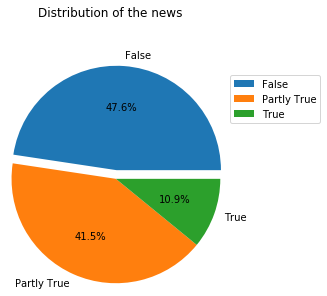

time: 166 ms


In [16]:
# plot the distribution
parties = ['False', 'Partly True', 'True']
plt.suptitle("Distribution of the news", y=1.1)
wedges, plt_labels, junk  = plt.pie(values , autopct='%1.1f%%', radius=1.2, labels=parties, explode=[0.1,0,0], shadow=False)
plt.legend(wedges, parties, bbox_to_anchor=(1.0,1.0), prop={'size':10})

- Percentage of fakenews over year

To see the trend of the distribution of the news over year, we first plotted a stackplot to show the amount of the true news and the fake news over years. Notice that we dropped the first three years' data because the data over these three years(1986, 2000 and 2004) is too little to give a reasonable percentage. It could be observed that the amount of fake news has a more conspicuous increasing trend than the amount of the true news. 

The second plot shows the percentage of the fake news in all three types of news over years. The overall trend of the percentage of the fake news is getting larger over years. Fake news in 2019 take a percentage of almost 60%, which indicating that fake news is probably an actual issue to be concerned about.

In [17]:
# convert date string to datetime
lst = []
for i in range(df_v.shape[0]):
    lst.append(parser.parse(df_v['date'][i]).date())
df_v['date'] = lst

time: 1.38 s


In [18]:
# get the value_counts() the dataframe by year
s = pd.DatetimeIndex(df_v['date']).year.value_counts()
lst_year = s.index.tolist()
lst_total = s.values.tolist()

time: 6.44 ms


In [19]:
# fetch the count of the false, partly true and true news and the percentage of false news over years
case0 = {}
case1 = {}
case2 = {}
dic_perc = {}
for i in range(len(lst_year)):
    case0[lst_year[i]] = 0
    case1[lst_year[i]] = 0
    case2[lst_year[i]] = 0
    num = 0
    tmp = df_v[pd.DatetimeIndex(df_v['date']).year == lst_year[i]]['label'].value_counts()
    tmp_index = tmp.index.tolist()
    tmp_value = tmp.values.tolist()
    for j in range(len(tmp_value)):
        if tmp_index[j] == 0:
            num = tmp_value[j]
            case0[lst_year[i]] = tmp_value[j]
        if tmp_index[j] == 1:
            case1[lst_year[i]] = tmp_value[j]
        if tmp_index[j] == 2:
            case2[lst_year[i]] = tmp_value[j]   
    dic_perc[lst_year[i]] = num/lst_total[i]

time: 116 ms


In [20]:
# sort the dictionaries by year ascending order
import collections
dic_perc = collections.OrderedDict(sorted(dic_perc.items()))
case0 = collections.OrderedDict(sorted(case0.items()))
case1 = collections.OrderedDict(sorted(case1.items()))
case2 = collections.OrderedDict(sorted(case2.items()))

time: 1.35 ms


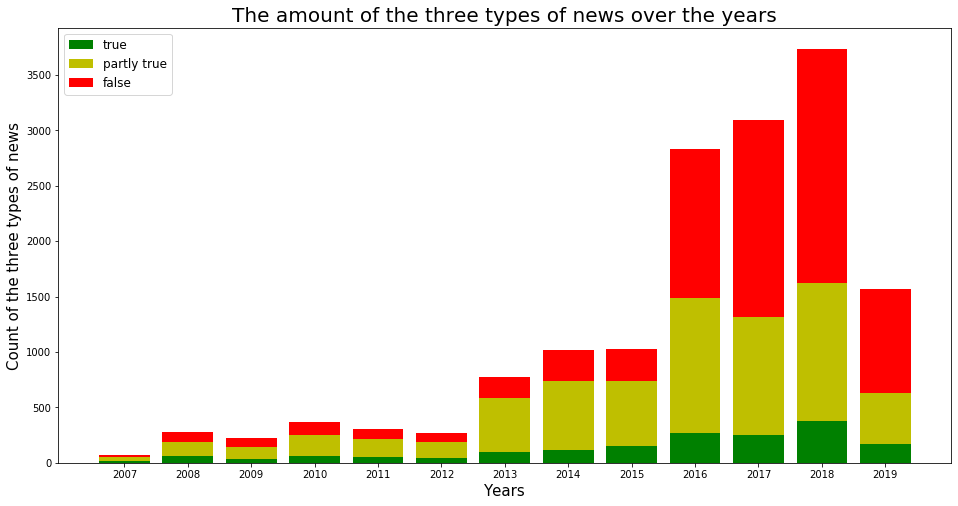

time: 493 ms


In [21]:
# show the three types of news
centers = list(case0.keys())[3:]
values_3 = list(case0.values())[3:]
values_2 = list(case1.values())[3:]
values_1 = list(case2.values())[3:]

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xticks(list(case0.keys())[3:])

plt.bar(x = centers, height = values_1, label = 'true', color = 'g')
plt.bar(x = centers, bottom=np.asarray(values_1), height = values_2, label = 'partly true', color = 'y')
plt.bar(x = centers, bottom=np.asarray(values_1) + np.asarray(values_2), height = values_3, label = 'false', color = 'r')

plt.xlabel("Years", fontsize=15)
plt.ylabel("Count of the three types of news", fontsize=15)
plt.title("The amount of the three types of news over the years", fontsize=20)
plt.legend(loc='upper left', fontsize=12)

Text(0.5, 1.0, 'The percentage of fake news over the years')

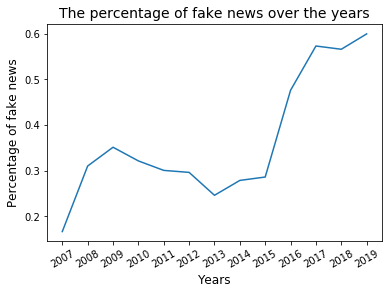

time: 264 ms


In [22]:
# plot the percentage of fake news over year
# drop the first three years (1986,2000,2004) becauase the data over the first three years is too little to give a reasonable percentage
plt.plot(list(dic_perc.keys())[3:], list(dic_perc.values())[3:])
plt.xticks(list(dic_perc.keys())[3:], rotation = 30)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Percentage of fake news", fontsize=12)
plt.title("The percentage of fake news over the years", fontsize=14)

- Percentage of fakenews over years based on 4 seasons

In the figures above, we tried to figure out the distribution over the years. Here, we are trying to see the distribution of fake news in different months. Instead of giving a plot for each month, we try to observe the distribution in seasons, where January to March is season 1, and April to Jun is season 2 and so on so forth. In the subplots, we could observe that total trend of the percentages of the fake news in all four seasons are increasing. For four seasons, the trends of the percentage of the fake news are slightly different before 2015, which are fluctuated. While the percentage of the fake news is increasing since 2015 for each season. 'Month' could be related to the number of fake news since things may happen in same months in years, like the Canadian elections. Therefore, we keep the 'month' as a feature.

In [23]:
# generate two new columns for month and year
df_v['month'] = pd.DatetimeIndex(df_v['date']).month
df_v['year'] = pd.DatetimeIndex(df_v['date']).year

time: 12.3 ms


In [24]:
# extract the news for each season
lst13 = [1,2,3]
df_13 = df_v[df_v['month'].isin(lst13)][['label', 'year', 'month']]
lst46 = [4,5,6]
df_46 = df_v[df_v['month'].isin(lst46)][['label', 'year', 'month']]
lst79 = [7,8,9]
df_79 = df_v[df_v['month'].isin(lst79)][['label', 'year', 'month']]
lst1012 = [10,11,12]
df_1012 = df_v[df_v['month'].isin(lst1012)][['label', 'year', 'month']]

time: 28.5 ms


In [25]:
# generate a function that take a dataframe of a season and returns a dictionary that takes years as keys and the frequency of fake new as values
def FakeFreqDic(df_v):
    lst_year = df_v['year'].value_counts().index.tolist()
    lst_total = df_v['year'].value_counts().values.tolist()
    dic_perc = {}
    for i in range(len(lst_total)):
        num = 0
        tmp = df_v[df_v['year'] == lst_year[i]]['label'].value_counts()
        tmp_index = tmp.index.tolist()
        tmp_value = tmp.values.tolist()
        for j in range(len(tmp_value)):
            if tmp_index[j] == 0:
                num = tmp_value[j]
        dic_perc[lst_year[i]] = num/lst_total[i]
        
    # drop the data in these three year: 1986, 2000, 2004 because the amount of data in these three years are too little to give information
    if 1986 in lst_year:
        del dic_perc[1986]
    if 2000 in lst_year:
        del dic_perc[2000]
    if 2004 in lst_year:
        del dic_perc[2004]   
    dic_perc = collections.OrderedDict(sorted(dic_perc.items()))
    
    return list(dic_perc.keys()), list(dic_perc.values())

time: 4.88 ms


In [26]:
# obtain the dictionaries of the 4 seasons, and drop the data in these three year: 1986, 2000, 2004,
# because the amount of data in these three years are too little to give information
lst_keys_13, lst_values_13 = FakeFreqDic(df_13)
lst_keys_46, lst_values_46 = FakeFreqDic(df_46)
lst_keys_79, lst_values_79 = FakeFreqDic(df_79)
lst_keys_1012, lst_values_1012 = FakeFreqDic(df_1012)
lst_year = [lst_keys_13, lst_keys_46, lst_keys_79, lst_keys_1012]
lst_freq = [lst_values_13, lst_values_46, lst_values_79, lst_values_1012]

time: 140 ms


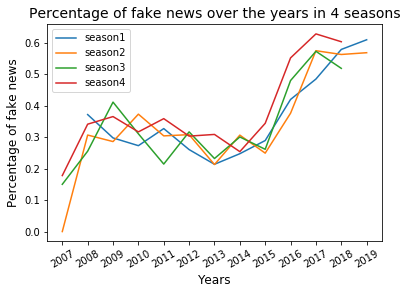

time: 301 ms


In [28]:
lst_label = ['season1', 'season2', 'season3',  'season4']
for i in range(4):
    plt.plot(lst_year[i], lst_freq[i], label = lst_label[i])
plt.title("Percentage of fake news over the years in 4 seasons", fontsize=14)
plt.ylabel('Percentage of fake news', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.xticks(lst_year[1], rotation = 30)
plt.legend()
plt.show()

- Word cloud of all the claims

From a word cloud, we could tell which words are more frequent to occur in the claims. The first word cloud is from the original claims before tf-idf, while the words are converted to lowercase and the stopwords are removed. The stopwords used here is from Quercus instead of nltk. The second word cloud was generated after doing tf-idf to the cleaned claims, which helped lower the frequency of some common words between claims. We could observe that some big words in the first graph like 'year' and 'state' are not that big in the second graph, which means there words are quite common that might appear in most of the claims. The third graph shows the frequency of the top 20 most frequent words after tf-idf, we could observe that the top words are political-related, like 'trump', 'president' and 'obama'.

In [29]:
# instead of using the stopwords in 'nltk', we use the stopwords file given on Quercus
# Loading the stop_word.txt file for removing the stop words
stop_words = open('stop_words.txt').read().split()

time: 9.99 ms


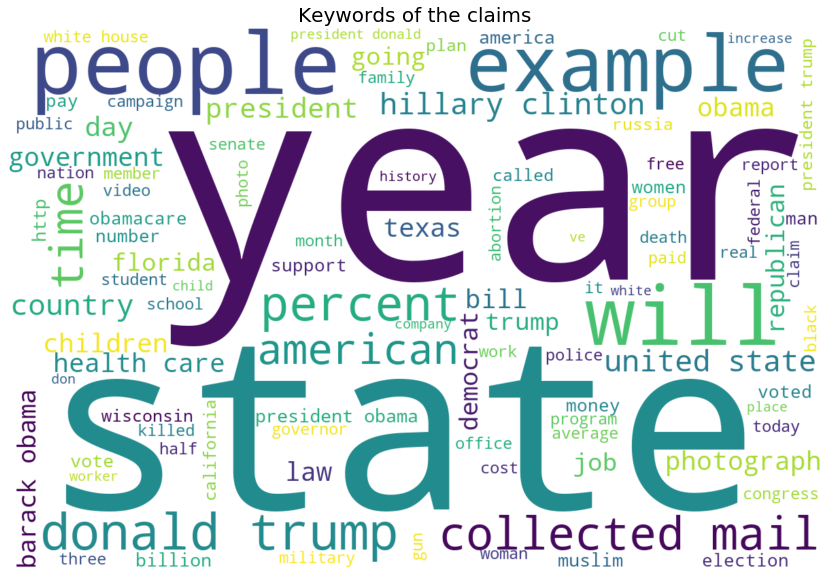

time: 5.42 s


In [30]:
# plot the word cloud of the original claims
# convert the words into lowercase and ingore the stopwords
claim_string = ''.join([x for x in df_v['claim']]).lower()
wordcloud = WordCloud(stopwords=stop_words, background_color="white", max_words=100, width = 1200, height = 800).generate(claim_string)
plt.figure(figsize = (20,10))
plt.title('Keywords of the claims', fontsize=20)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [31]:
# clean the claims before doing tf-idf
# convert the words into lowercase and remove the stopwords
all_claim = []
for row in range(df_v.shape[0]):
    tmp = df_v['claim'][row]
    b = tokenizer.tokenize(tmp.lower()) # Lower case and tokenize
    words_rmStop = [word for word in b if word not in stop_words] # Remove stop words
    claimCleaned = " ".join(words_rmStop)
    all_claim.append(claimCleaned)
df_v['claim'] = all_claim

time: 3.62 s


In [32]:
# this is a function that takes the vectorizer and the result array of the tf-idf,
# and sort them by the sum of tf-idf (means frequency of the words)
def display_scores(vectorizer, tfidf_result):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return sorted_scores

time: 2.06 ms


In [33]:
# a functions that takes the sorted result, and returns a dictionary: words as keys and frequency as values
def convertDic(sorted_scores):
    lst_feat, lst_freq = map(list, zip(*sorted_scores))
    dic = {}
    for i in range(len(lst_feat)):
        dic[lst_feat[i]] = lst_freq[i]
    return dic

time: 3.45 ms


In [34]:
# do tf-idf on all the claims and receive the frequency dictionary
# choose top 100
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, max_features=100, ngram_range=[1,2])
array_TFIDF = vectorizer.fit_transform(all_claim).toarray()
sorted_scores = display_scores(vectorizer, array_TFIDF)
dic = convertDic(sorted_scores)

time: 1.76 s


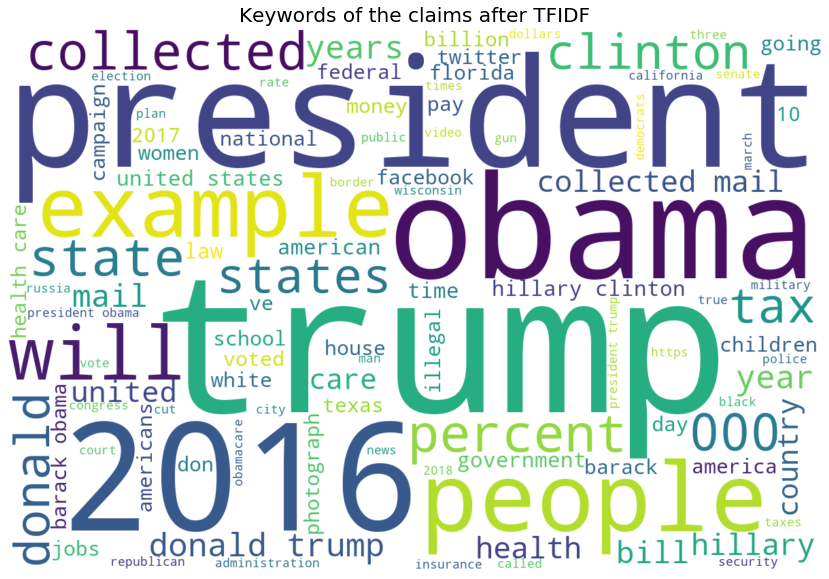

time: 3.32 s


In [35]:
# generate a word cloud of the claims after doing tf-idf
wordcloud = WordCloud(stopwords=stop_words, background_color="white", max_words=100, width = 1200, height = 800).generate_from_frequencies(dic)
plt.figure(figsize = (20,10))
plt.title('Keywords of the claims after TFIDF', fontsize=20)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'The top 20 most frequent words')

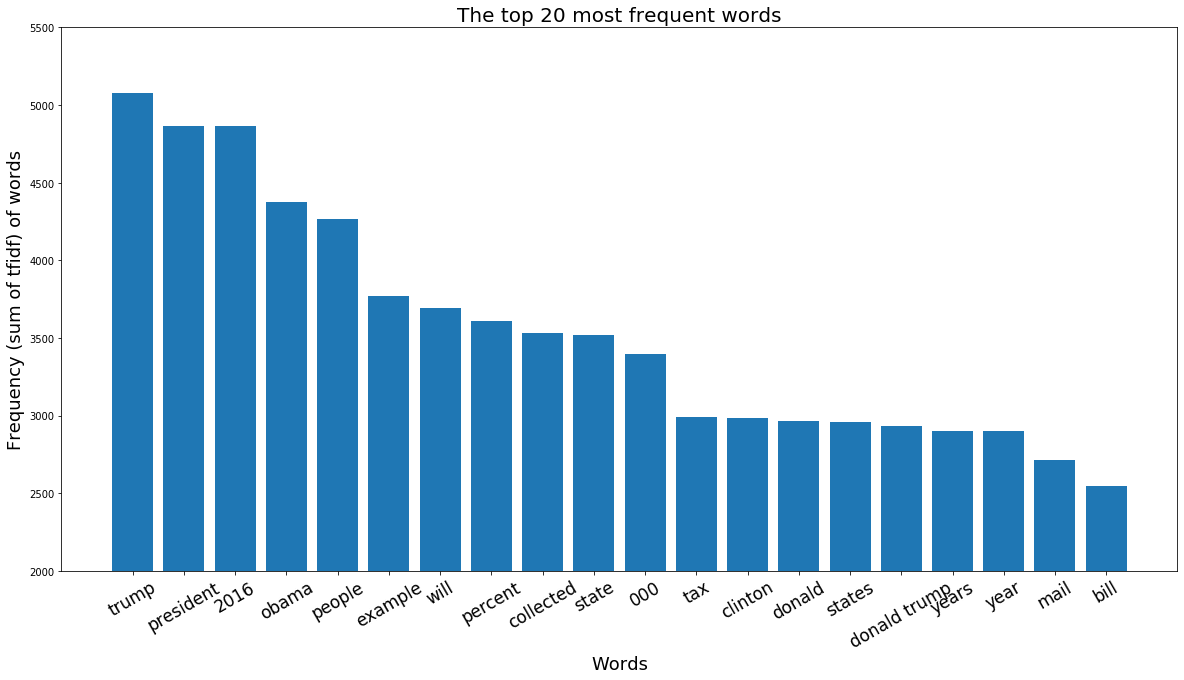

time: 578 ms


In [36]:
# plot the frequency of the top 20 most frequent words after tf-idf
lst_feat = list(dic.keys())
lst_freq = list(dic.values())
plt.figure(figsize=(20,10))
plt.bar(lst_feat[:20], lst_freq[:20])
plt.xticks(lst_feat[:20], rotation = 30, fontsize=17)
plt.xlabel("Words", fontsize=18)
plt.ylim(ymax=5500, ymin=2000)
plt.ylabel("Frequency (sum of tfidf) of words", fontsize=18)
plt.title("The top 20 most frequent words", fontsize=20)

- Word clouds of the three types of claims

In the above graphs, we saw the keywords in the range of all claims, while here we want to see what frequent words that different types of claims might have used. We generated three word clouds for the three types of claims after doing tf-idf: false, partly true and true. Notice that though the frequent words are common in the three graphs, the frequency of the words can be different.

In [37]:
# divide the dataset by label and plot the word cloud of each type of news after tf-idf
claim_0 = df_v[df_v['label'] == 0]['claim'].tolist()
claim_1 = df_v[df_v['label'] == 1]['claim'].tolist()
claim_2 = df_v[df_v['label'] == 2]['claim'].tolist()

time: 14.7 ms


In [38]:
# use the same vectorizer to calculate tfidf and get the dictionary of words and frequency
# false news
array0_TFIDF = vectorizer.fit_transform(claim_0).toarray()
sorted_scores0 = display_scores(vectorizer, array0_TFIDF)
dic0 = convertDic(sorted_scores0)
# partly true
array1_TFIDF = vectorizer.fit_transform(claim_1).toarray()
sorted_scores1 = display_scores(vectorizer, array1_TFIDF)
dic1 = convertDic(sorted_scores1)
# true
array2_TFIDF = vectorizer.fit_transform(claim_2).toarray()
sorted_scores2 = display_scores(vectorizer, array2_TFIDF)
dic2 = convertDic(sorted_scores2)

time: 1.56 s


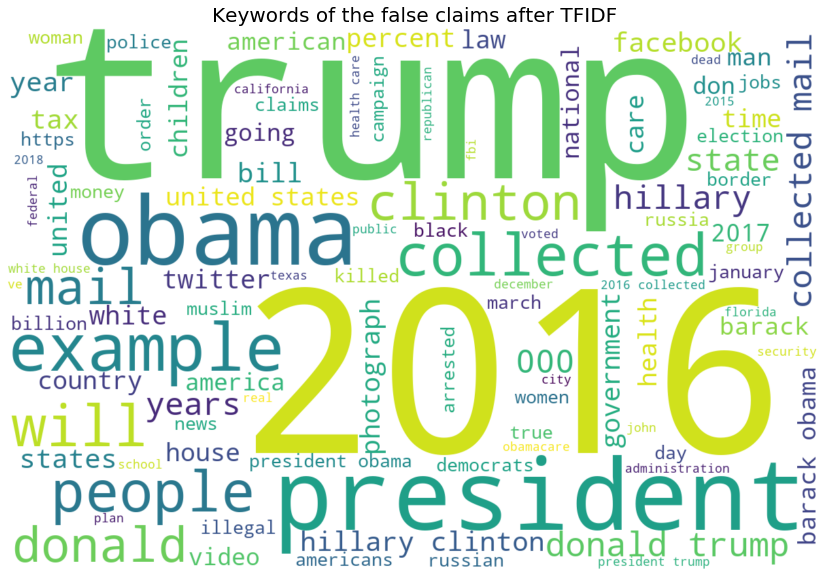

time: 3.16 s


In [39]:
# generate a word cloud of the false claims after doing tf-idf
wordcloud = WordCloud(stopwords=stop_words, background_color="white", max_words=100, width = 1200, height = 800).generate_from_frequencies(dic0)
plt.figure(figsize = (20,10))
plt.title('Keywords of the false claims after TFIDF', fontsize=20)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

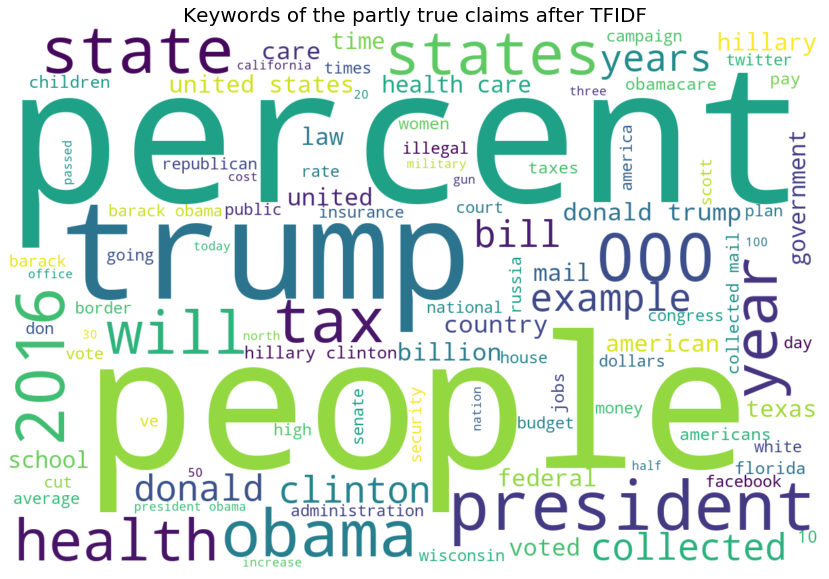

time: 3.27 s


In [40]:
# generate a word cloud of the partly true claims after doing tf-idf
wordcloud = WordCloud(stopwords=stop_words, background_color="white", max_words=100, width = 1200, height = 800).generate_from_frequencies(dic1)
plt.figure(figsize = (20,10))
plt.title('Keywords of the partly true claims after TFIDF', fontsize=20)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

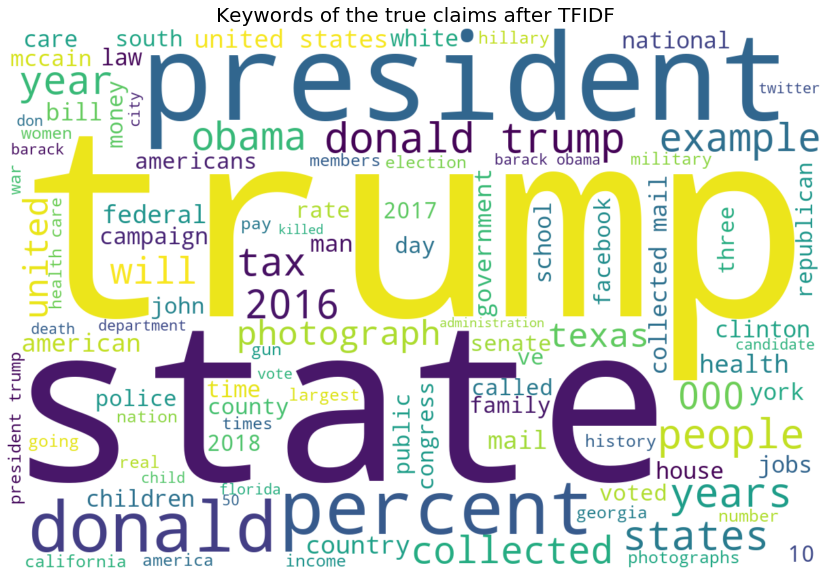

time: 3.28 s


In [41]:
# generate a word cloud of the true claims after doing tf-idf
wordcloud = WordCloud(stopwords=stop_words, background_color="white", max_words=100, width = 1200, height = 800).generate_from_frequencies(dic2)
plt.figure(figsize = (20,10))
plt.title('Keywords of the true claims after TFIDF', fontsize=20)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

- The claimants who tend to give more false news

Here we want to see the correlation between the claimants and the labels. Notice that there are 301 claimants have more than 5 news in the dataset, 140 claimants have more than 10 news in the dataset, and 21 claimants have more than 50 news in the data set. We selected the top 21 claimants that give the most news in the dataset and plotted the percentage of fake news. As shown in the first figure, 'various websites', 'multiple sources', 'viral images' and other social media networks tend to have higher percentage of fake news. In order to see the amount of fake news, we plotted the second graph, which tells us Donald Trump has more than 1200 news in the dataset and more than half of them are false. We could observe the quantities of the three types of news from the second graph.

In [42]:
claimants = df_v[df_v['claimant'] != '']['claimant'].value_counts()
len(claimants[claimants.values >= 5]), len(claimants[claimants.values >= 10]), len(claimants[claimants.values >= 50])

(301, 140, 21)

time: 36.3 ms


In [43]:
# take the 21 claimants that have 50 or more than 50 related claims 
claimants = claimants[:21]
lst_name = claimants.index
total = claimants.values.tolist()
# calculate the occurrence of three types of news for each claimants and the ratio of the fake news to all news related to the claimants
dic_claimants = {}
case0 = []
case1 = []
case2 = []
new = df_v.loc[df_v['claimant'].isin(lst_name)]
for i in range(len(lst_name)):
    case0.append(0)
    case1.append(0)
    case2.append(0)
    tmp = new[new['claimant'] == lst_name[i]]['label'].value_counts()
    tmp_index = tmp.index.tolist()
    tmp_value = tmp.values.tolist()
    for j in range(len(tmp_value)):
        if tmp_index[j] == 0:
            this_case = tmp_value[j]
            case0[i] = tmp_value[j]
        if tmp_index[j] == 1:
            case1[i] = tmp_value[j]
        if tmp_index[j] == 2:
            case2[i] = tmp_value[j]        
    dic_claimants[lst_name[i]] = this_case/total[i]
dic_claimants

{'Donald Trump': 0.6658556366585564,
 'Bloggers': 0.8306451612903226,
 'Barack Obama': 0.1794871794871795,
 'Hillary Clinton': 0.21363636363636362,
 'Viral image': 0.905511811023622,
 'Facebook posts': 0.7314814814814815,
 'Various websites': 1.0,
 'Ted Cruz': 0.3490566037735849,
 'Bernie Sanders': 0.1485148514851485,
 'Marco Rubio': 0.21649484536082475,
 'Scott Walker': 0.2,
 'John McCain': 0.25,
 'Rick Perry': 0.2857142857142857,
 'Rick Scott': 0.1643835616438356,
 'Chain email': 0.8591549295774648,
 'Facebook user': 0.8169014084507042,
 'multiple sources': 0.9857142857142858,
 'Mike Pence': 0.48333333333333334,
 'Jeb Bush': 0.10344827586206896,
 'Paul Ryan': 0.17647058823529413,
 'Multiple sources': 0.86}

time: 140 ms


In [44]:
# convert the keys and the values in the dictionary
def invert_dict(d):
    return dict([(v, k) for k, v in d.items()])

time: 1.41 ms


In [45]:
# order the dictionary by frequency of the fake news
dic_claimants = invert_dict(dic_claimants)
dic_claimants = collections.OrderedDict(sorted(dic_claimants.items(), reverse =True))

time: 1.48 ms


Text(0.5, 1.0, 'Percentage of fake news of the top 21 claimants who have the most related news')

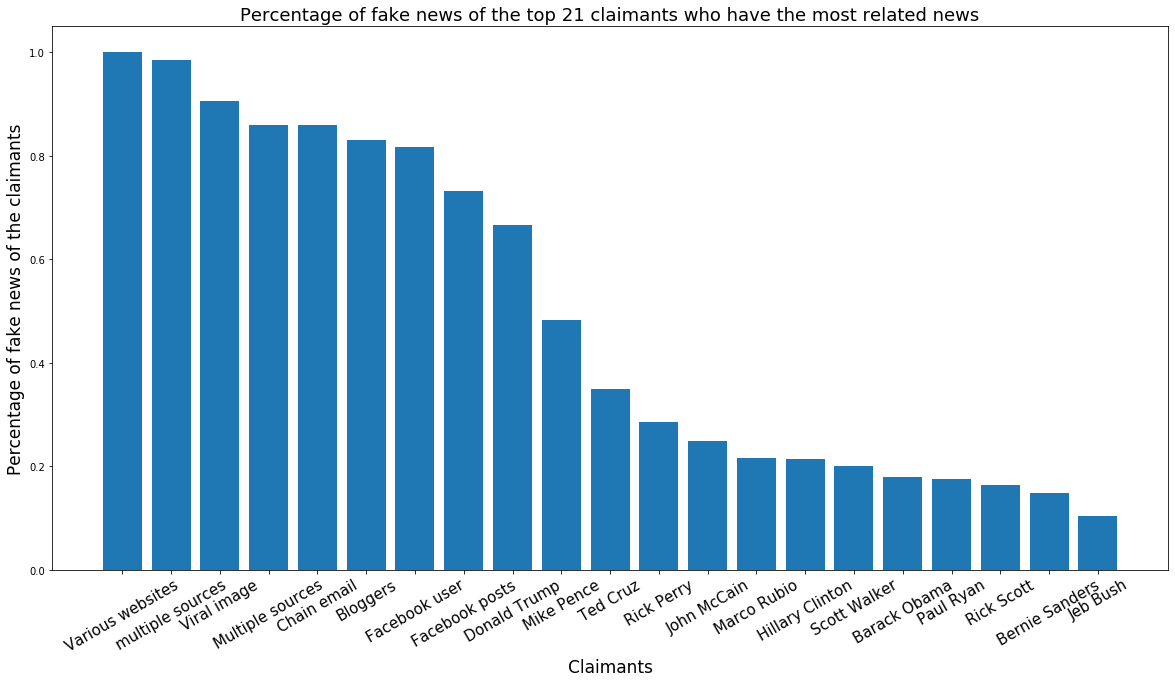

time: 610 ms


In [46]:
# plot the percentage of fake news of the top 21 claimants who have the most related news
plt.figure(figsize=(20,10))
plt.bar(list(dic_claimants.values()), list(dic_claimants.keys()))
plt.xticks(list(dic_claimants.values()), rotation = 30, fontsize = 15)
plt.xlabel("Claimants",fontsize = 17)
plt.ylabel("Percentage of fake news of the claimants", fontsize = 17)
plt.title("Percentage of fake news of the top 21 claimants who have the most related news", fontsize = 18)

Text(0.5, 1.0, 'Top 21 claimants who posted the most news')

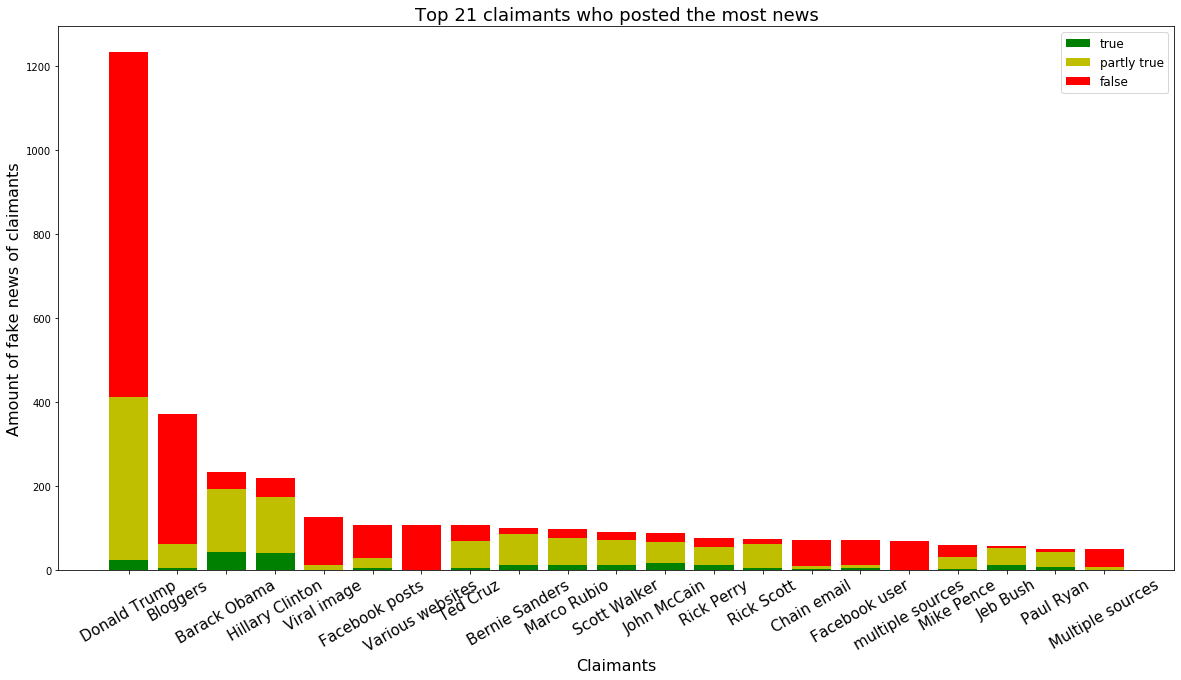

time: 750 ms


In [47]:
# plot the amount of fake news of the top 21 claimants who have the most related news
lst_x = []
for i in range(21):
    lst_x.append(i)
centers = lst_name

fig, ax = plt.subplots(figsize=(20,10))
ax.set_xticklabels(lst_name, rotation = 30, fontsize = 15)

plt.bar(x = centers, height = case2, label = 'true', color = 'g')
plt.bar(x = centers, bottom=np.asarray(case2), height = case1, label = 'partly true', color = 'y')
plt.bar(x = centers, bottom=np.asarray(case1) + np.asarray(case2), label = 'false', height = case0, color = 'r')

plt.legend(loc='upper right', fontsize=12)
plt.xlabel("Claimants", fontsize = 16)
plt.ylabel("Amount of fake news of claimants", fontsize = 16)
plt.title("Top 21 claimants who posted the most news", fontsize =18)

- The sentiment of the three types of news

We plotted the sentiment of the three types of news in subplots. As shown in the figure, most of the sentiments of true news are positive. Sentiments of false news and partly true news have similar distribution, and most of the sentiments are around 0. True news tend to be more positive because most of the sentiments are around 0.1.

In [48]:
df_v['sentiment'] = features['sentiment'].tolist()

time: 5.5 ms


In [49]:
# get lists of the sentiments belonged to the three types
sent_0 = df_v[df_v['label'] ==0]['sentiment'].tolist()
sent_1 = df_v[df_v['label'] ==1]['sentiment'].tolist()
sent_2 = df_v[df_v['label'] ==2]['sentiment'].tolist()

time: 16.2 ms


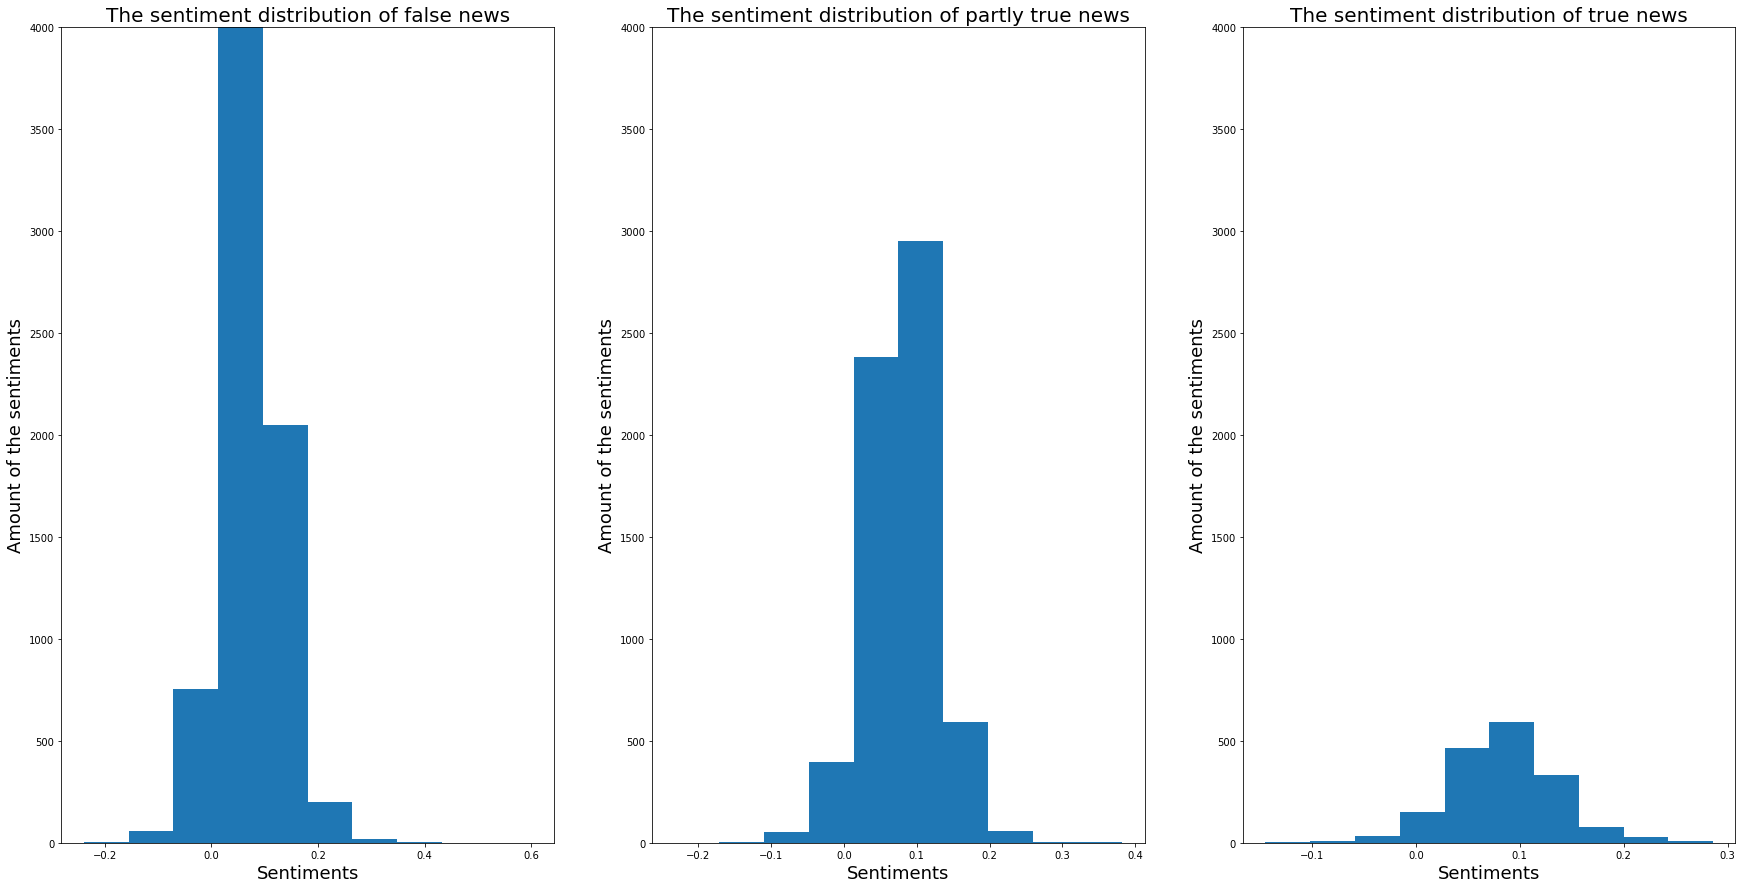

time: 1.03 s


In [50]:
# plot the sentiment 
rows = 1
cols = 3
size = (30, 15)

# Create rows x cols subplot of size size
fig, ax = plt.subplots(rows, cols, figsize = size)
lst_sent = [sent_0, sent_1, sent_2]
lst_title = ['false', 'partly true', 'true']

for j in range(cols):
    ax[j].hist(lst_sent[j])
    ax[j].set_ylim(0, 4000)
    ax[j].set_xlabel('Sentiments', fontsize=18)
    ax[j].set_ylabel('Amount of the sentiments', fontsize=18)
    ax[j].set_title("The sentiment distribution of "+ lst_title[j] +" news", fontsize=20)


## Modelling

We will try using XGBoost, random forests, and logistic regression models and compare their performance. 

In [51]:
# XGBoost classifier
xgb_clf = XGBClassifier(eta = 0.3, max_depth = 6, objective= 'multi:softprob', num_class = 3)
xgb_model = xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_report = classification_report(y_test, xgb_pred, digits = 3)

time: 1min 40s


In [52]:
# Random forest classifier
rf_clf = RandomForestClassifier(criterion = 'entropy', n_estimators = 10, random_state = SEED).fit(X_train, y_train)
rf_model = rf_clf.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_report = classification_report(y_test, rf_pred, digits = 3)

time: 1.71 s


Since L2 regression is used in the logistic regression model, we need to standardize the data first.

In [53]:
# Standardize the train and test data
scaler = StandardScaler()
_ = scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

time: 263 ms


In [54]:
# Logistic regression classifier
lr_clf = LogisticRegression(penalty = 'l2', multi_class = 'ovr', solver = 'liblinear')
lr_model = lr_clf.fit(X_train_std, y_train)
lr_pred = lr_model.predict(X_test_std)
lr_report = classification_report(y_test, lr_pred, digits = 3)

time: 8.17 s


## Results
Below are the classification reports of the three models.  Comparing the macro F1 scores, XGBoost performed the best with an F1 score of 42% and accuracy of 59%.  All 3 models with were weak at classifying class 2 (TRUE), having F1 scores between 1% and 3%.  This may be due to the fact that the training data was unbalanced with only 11% of training examples belonging to class 2.

In [55]:
print("########### XGBoost Classification Report ###########")
print(xgb_report, "\n")
print("####### Random Forests Classification Report #######")
print(rf_report, "\n")
print("##### Logistic Regression Classification Report #####")
print(lr_report, "\n")

########### XGBoost Classification Report ###########
              precision    recall  f1-score   support

           0      0.605     0.719     0.657      2192
           1      0.577     0.601     0.589      1972
           2      0.500     0.012     0.023       503

    accuracy                          0.593      4667
   macro avg      0.561     0.444     0.423      4667
weighted avg      0.582     0.593     0.560      4667
 

####### Random Forests Classification Report #######
              precision    recall  f1-score   support

           0      0.548     0.672     0.604      2192
           1      0.517     0.504     0.510      1972
           2      0.148     0.018     0.032       503

    accuracy                          0.530      4667
   macro avg      0.404     0.398     0.382      4667
weighted avg      0.492     0.530     0.503      4667
 

##### Logistic Regression Classification Report #####
              precision    recall  f1-score   support

           0      

We also take a look at the performance on classifying training data. We see that the random forest classification has a much higher train F1 score (98%) compared to the test F1 score (38%).  This is an indication that it is overfit to the train data, hence why it performed the worse on the test data.  The XGBoost classifier's train F1 score is 9% higher than the test F1 score.  This is a good indication that the model is neither overfit or underfit.

In [56]:
xgb_report_train = classification_report(y_train, xgb_model.predict(X_train))
rf_report_train = classification_report(y_train, rf_model.predict(X_train))
lr_report_train = classification_report(y_train, lr_model.predict(X_train))

print("########### XGBoost Classification Report ###########")
print(xgb_report_train, "\n")
print("####### Random Forests Classification Report #######")
print(rf_report_train, "\n")
print("##### Logistic Regression Classification Report #####")
print(lr_report_train, "\n")

########### XGBoost Classification Report ###########
              precision    recall  f1-score   support

           0       0.69      0.80      0.74      5216
           1       0.66      0.71      0.68      4479
           2       0.97      0.06      0.11      1193

    accuracy                           0.68     10888
   macro avg       0.77      0.52      0.51     10888
weighted avg       0.71      0.68      0.65     10888
 

####### Random Forests Classification Report #######
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      5216
           1       0.99      0.98      0.98      4479
           2       1.00      0.92      0.96      1193

    accuracy                           0.98     10888
   macro avg       0.99      0.97      0.98     10888
weighted avg       0.98      0.98      0.98     10888
 

##### Logistic Regression Classification Report #####
              precision    recall  f1-score   support

           0      

/Users/michael/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


To understand where the misclassifications happen, we take a look at the confusion matrix for the XGBoost classifier.

In [57]:
# Confusion matrix code obtained from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

time: 5.83 ms


We can see that that 99% of class 2 samples were misclassified by approximately half in class 0 and half in class 1.  Class 0 was misclassified as class 1 28% of the time and class 1 was misclassified as class 0 40% of the time. 

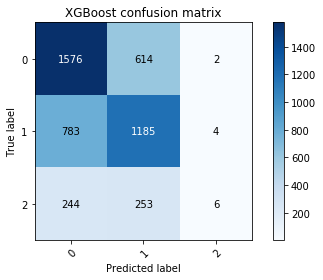

time: 373 ms


In [58]:
# Plot confusion matrix
plot_confusion_matrix(y_test, xgb_pred, classes = [0,1,2], title='XGBoost confusion matrix')
plt.show()

## Model Tuning
Since XGBoost performed the best, we will perform cross validation grid search to tune the hyperparameters.

In [ ]:
# Saved to gsResults.json to prevent running this expensive code again

# Grid search
# parameters = {'max_depth': (6,7,8), 'min_child_weight': (1,2,3)}
# gs = GridSearchCV(xgb_clf, parameters, cv = 3, scoring = 'f1_macro', return_train_score = True)
# gs.fit(X_train, y_train)

In [59]:
#gsResults = pd.DataFrame.from_dict(gs.cv_results_)
gsResults = pd.read_json("gsResults2.json")
gsResults

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,59.872495,1.989538,0.200098,0.013453,6,1,"{'max_depth': 6, 'min_child_weight': 1}",0.418940,0.418961,0.424959,0.420953,0.002832,3,0.549363,0.542940,0.529799,0.540701,0.008142
1,65.264178,5.295185,0.191569,0.008191,6,2,"{'max_depth': 6, 'min_child_weight': 2}",0.417667,0.426421,0.420581,0.421556,0.003640,1,0.541735,0.541841,0.542865,0.542147,0.000510
2,59.283329,1.581852,0.186185,0.002955,6,3,"{'max_depth': 6, 'min_child_weight': 3}",0.409380,0.417645,0.419118,0.415380,0.004286,8,0.528856,0.528765,0.535597,0.531073,0.003199
3,73.233265,8.692656,0.219184,0.013606,7,1,"{'max_depth': 7, 'min_child_weight': 1}",0.413284,0.426161,0.423430,0.420958,0.005540,2,0.617372,0.616090,0.597437,0.610300,0.009110
4,72.871555,7.776028,0.213722,0.011894,7,2,"{'max_depth': 7, 'min_child_weight': 2}",0.415146,0.425318,0.420787,0.420417,0.004161,5,0.615560,0.605574,0.615778,0.612304,0.004760
5,65.559233,1.885591,0.210522,0.005730,7,3,"{'max_depth': 7, 'min_child_weight': 3}",0.407572,0.417638,0.415133,0.413447,0.004279,9,0.604720,0.619793,0.600422,0.608312,0.008306
6,74.836631,5.008432,0.219695,0.004897,8,1,"{'max_depth': 8, 'min_child_weight': 1}",0.415866,0.421303,0.425054,0.420740,0.003772,4,0.701466,0.693260,0.671080,0.688602,0.012835
7,76.887052,3.629946,0.253687,0.037241,8,2,"{'max_depth': 8, 'min_child_weight': 2}",0.412517,0.421572,0.420619,0.418236,0.004063,6,0.690426,0.686250,0.678926,0.685201,0.004753
8,78.571445,5.170715,0.227691,0.004743,8,3,"{'max_depth': 8, 'min_child_weight': 3}",0.408379,0.423461,0.417420,0.416420,0.006198,7,0.689638,0.688096,0.681881,0.686538,0.003353


time: 86.7 ms


From the grid search results, we see that our original parameters of max depth of 6 and minimum child weight of 1 was already optimal.  Therefore, we left the model parameters the same.  Below is a graph of the train and cross validation error.  We see that the train error increases while the cross validation error remains relatively the same.  This is an indication that we have a good bias-variance tradeoff.

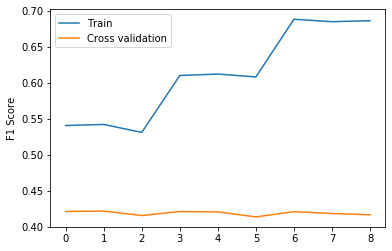

time: 401 ms


In [60]:
_ = plt.plot(gsResults['mean_train_score'], label = "Train")
_ = plt.plot(gsResults['mean_test_score'], label = "Cross validation")
_ = plt.ylabel('F1 Score')
_ = plt.legend()

In [ ]:
pickle.dump(enc, open("encoder.sav", 'wb'))
pickle.dump(xgb_model, open("xgb1.sav", 'wb'))